In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [10]:
def run_sim(k_in):
    #1) Initialize parameters.
    tmax = 5000
    dt = 0.01

    #1.1) Neuron/Network pairs.
    c_m = 50 # nF
    v_th = -55 # mV
    v_r = -75 # mV
    g_l = 15 # nS
    e_l = v_r # mV
    v_spike = 20 # mV

    # Bursting parameters
    tau_a = 5 # s
    k_a = 5150 # Pa
    k_e = 600 # Pa

    # PIEZO channel parameters
    g_s = 25 # nS
    e_srev = 10 # mV
    s = .00277 # 1/Pa
    k_b = 106
    m = 25
    q = 1

    #2) Reserve memory
    T = int(np.ceil(tmax / dt))
    v = np.zeros(T)
    sigma_m = np.zeros(T)
    sigma_a = np.zeros(T)
    sigma_w = np.zeros(T)
    i_s = np.zeros(T)

    #2.1) Initialize
    spikes = []
    v[0] = -75 #Resting potential
    sigma_a[0] = 0
    sigma_w[0] = 25000
    sigma_m[0] = sigma_a[0] + sigma_w[0]
    
    #3) For-loop over time.
    for t in np.arange(T-1):
        if v[t] < v_th:
            #3.1) Update DOE.
            i_s[t+1] = g_s / (1 + k_b * np.exp(- s * (sigma_m[t] / m) ** q)) * (v[t] - e_srev)
            i_l = g_l * (v[t] - e_l)
            # update membrane potential
            dv = 1 / c_m * (- i_l - i_s[t])
            v[t+1] = v[t] + dv*dt
            # update active stress
            dsigma_a = - sigma_a[t] / tau_a
            sigma_a[t+1] = sigma_a[t] + dsigma_a * dt
            # update vacuole volume
            dsigma_w = k_in
            sigma_w[t+1] = sigma_w[t] + dsigma_w * dt
        else:
            #3.2) Spike!
            v[t] = 20
            v[t+1] = v_r
            sigma_a[t+1] = sigma_a[t] + k_a
            sigma_w[t+1] = sigma_w[t] - k_e
            i_s[t+1] = i_s[t]
            spikes.append(t*dt)
        
        # update muscle stress
        sigma_m[t+1] = sigma_w[t+1] + sigma_a[t+1]
    
    # Throw the warm-up period
    spikes_ = []
    for x in spikes:
        if x >= 500:
            spikes_.append(x)
    spikes = spikes_
    
    if not spikes:
        return None, None, None
    
    # Clustering
    clusters = []
    intervals = [spikes[i+1] - spikes[i] for i in range(len(spikes) - 1)]
    max_int, min_int = max(intervals), min(intervals)
    
    if min_int >= .9 * max_int:
        return None, None, None # filter out non-bursters
    
    for i, tspike in enumerate(spikes):
        if i == 0 or max_int - (tspike - spikes[i-1]) < .1 * max_int:
            clusters.append([tspike])
        else:
            clusters[-1].append(tspike) 
    
    # Filter out non-bursters
    n = len(clusters)
    m_li = [len(cluster) for cluster in clusters]
    if n == 1 or m_li.count(1) > 2:
        return None, None, None
    
    # Calculate metrics
    cb_cycle_time = max([clusters[i+1][0] - clusters[i][0] for i in range(len(clusters)-1)])
    cb_duration = max([cluster[-1] - cluster[0] for cluster in clusters])
    pulse_number_per_cb = max(m_li)
     
    return cb_cycle_time, cb_duration, pulse_number_per_cb

In [11]:
# Sweep k_a and k_e
cb_cycle_time_li = np.zeros(50)
cb_duration_li = np.zeros(50)
pulse_number_per_cb_li = np.zeros(50)

k_in_li = np.arange(0, 100, 2)
for i, k_in in enumerate(tqdm(k_in_li)):
    cb_cycle_time_li[i], cb_duration_li[i], pulse_number_per_cb_li[i] = run_sim(k_in)

100%|██████████| 50/50 [02:55<00:00,  3.52s/it]


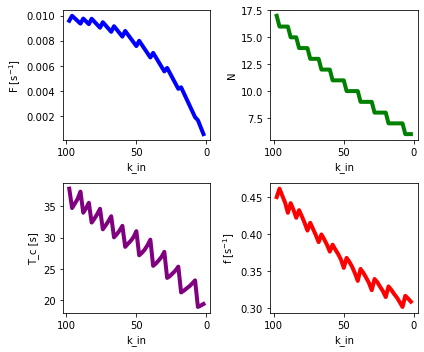

In [19]:
fig = plt.figure(figsize=(6, 5))
(ax1, ax2), (ax3, ax4) = fig.subplots(2, 2)

linewidth = 4
colors = ['b', 'g', 'purple', 'r']

# CB frequency
ax1.plot(k_in_li, 1 / cb_cycle_time_li, linewidth=linewidth, color=colors[0])
ax1.invert_xaxis()
ax1.set_xlabel('k_in')
ax1.set_ylabel(r'F [s$^{-1}$]')

# CB Pulse Number
# ax2.plot(k_in_li, 7200 / cb_cycle_time_li * pulse_number_per_cb_li, linewidth=linewidth, color=colors[1])
ax2.plot(k_in_li, pulse_number_per_cb_li, linewidth=linewidth, color=colors[1])
ax2.invert_xaxis()
ax2.set_xlabel('k_in')
ax2.set_ylabel('N')


# CB duration
# ax3.plot(k_in_li, 7200 / cb_cycle_time_li * cb_duration_li, linewidth=linewidth, color=colors[2])
ax3.plot(k_in_li, cb_duration_li, linewidth=linewidth, color=colors[2])
ax3.invert_xaxis()
ax3.set_xlabel('k_in')
ax3.set_ylabel('T_c [s]')


# CB pulse frequency
ax4.plot(k_in_li, pulse_number_per_cb_li / cb_duration_li, linewidth=linewidth, color=colors[3])
ax4.invert_xaxis()
ax4.set_xlabel('k_in')
ax4.set_ylabel(r'f [s$^{-1}$]')



# plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./output/k_in.png', dpi=300)
plt.show()